In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import numpy as np
from torch.utils.data import DataLoader
sys.path.append('..')
from load_data import load_data, Dataset
from config import xvertseg_dir, verse2019_dir, resolution, patch_size, batch_size
from tiger.patches import PatchExtractor3D
import torch
from monai.transforms import Compose, RandGaussianNoise, RandRotate, RandGaussianSmooth, RandGaussianSharpen, Rand3DElastic

In [2]:
# load data from corresponding data dir
xvertseg_imgs, xvertseg_msks, xvertseg_scores = load_data(xvertseg_dir)

Loading images from /mnt/netcache/bodyct/experiments/vertebra_fracture_detection_t9560/datasets/xvertseg/images...


  0%|          | 0/15 [00:00<?, ?it/s]

Loading masks from /mnt/netcache/bodyct/experiments/vertebra_fracture_detection_t9560/datasets/xvertseg/masks...


  0%|          | 0/15 [00:00<?, ?it/s]

In [3]:
# make a dataset
np_scores = xvertseg_scores.to_numpy()
dataset = Dataset(np_scores[:1], xvertseg_imgs[:1], xvertseg_msks[:1], patch_size)

  0%|          | 0/1 [00:00<?, ?it/s]

Images norm mean:-1.644517855226013e-16, std: 1.0000000000000007
Masks norm mean:-7.333543494691952e-17, std: 1.000000000000005


In [6]:
img_patches = dataset.get_images()
msk_patches = dataset.get_masks()

# plotting we need the min and maxes
img_min, img_max = np.min(img_patches), np.max(img_patches)
msk_min, msk_max = np.min(msk_patches), np.max(msk_patches)

In [12]:
# define transforms
spatial_transforms = [RandRotate(range_x=0.35, range_y=0.35, range_z=0, prob=1, mode='nearest')]
other_transforms = [RandGaussianNoise(prob=1, mean=0, std=0.5), 
                    RandGaussianSmooth(prob=1, sigma_x=(0, 1.5), sigma_y=(0, 1.5), sigma_z=(0, 1.5))]

names = ['Rotate', 'Gaussian Noise', 'Gaussian Smooth']

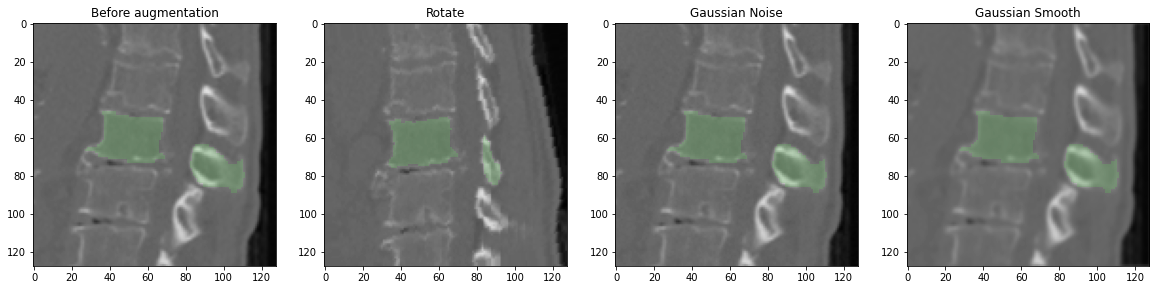

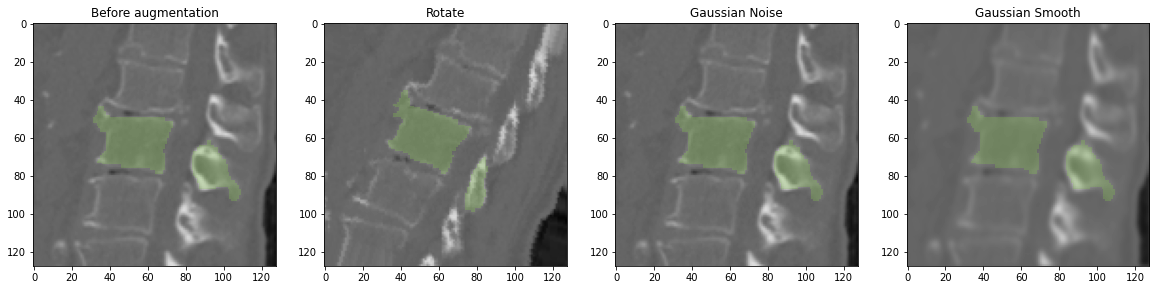

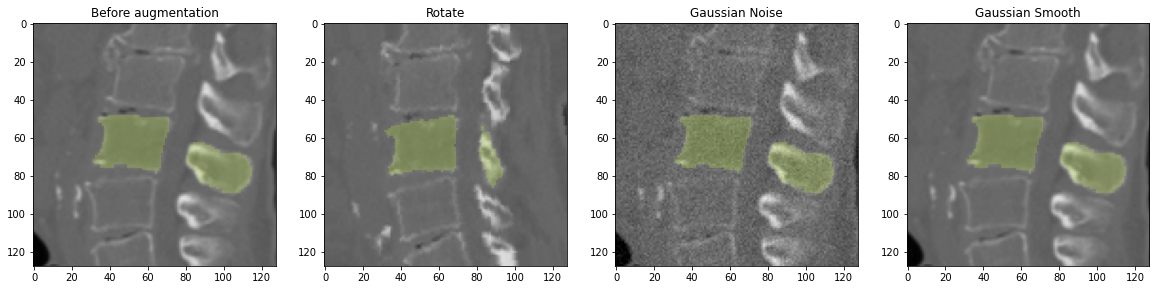

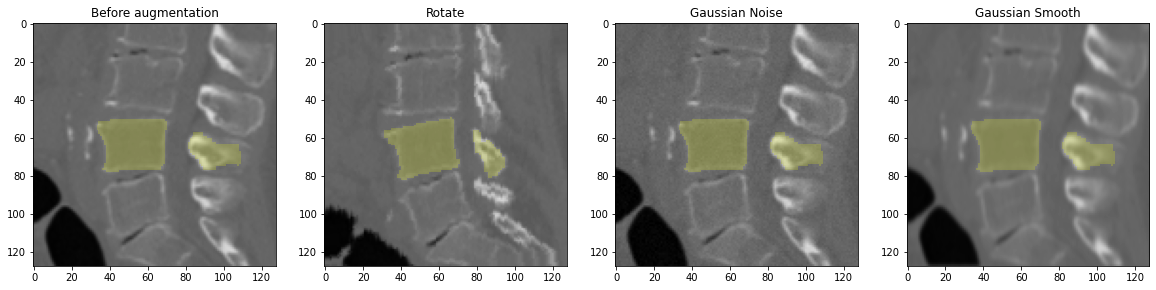

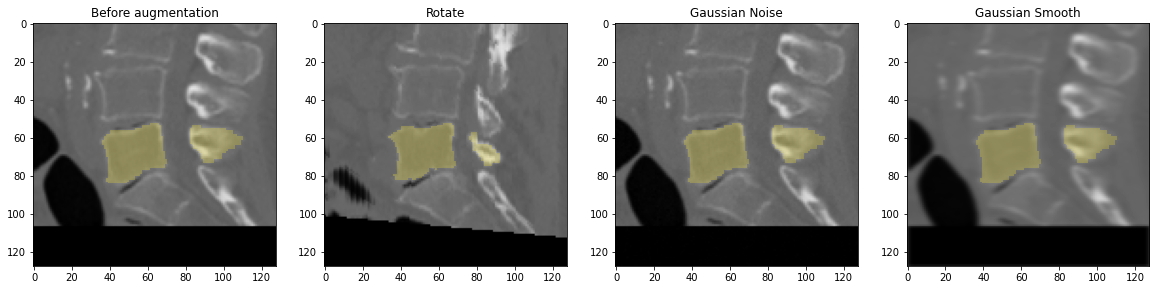

In [22]:
for img, msk in zip(img_patches, msk_patches):
    
    # save transforms
    augs = []
    
    for transform in spatial_transforms:
        trans = transform(np.stack((img, msk)))
        augs.append((trans[0], trans[1]))

    for transform in other_transforms: 
        # only apply transform on the imgs
        augs.append((transform(img), msk))
    
    num_augs = len(augs)
    
    # plot the normal image
    plt.figure(figsize=(20, 10))
    mid_slice = img.shape[0] // 2
    plt_msk = np.ma.masked_where(msk == np.min(msk), msk)      
    
    plt.subplot(1, num_augs + 1, 1)
    plt.imshow(img[mid_slice, :, :], cmap='gray', vmin=img_min, vmax=img_max)
    plt.imshow(plt_msk[mid_slice, :, :], alpha=0.25, vmin=msk_min, vmax=msk_max)
    plt.title('Before augmentation')  
    
    # plot the tranforms
    for i, (img, msk) in enumerate(augs):
        plt_msk = np.ma.masked_where(msk == np.min(msk), msk)  

        plt.subplot(1, num_augs + 1, i + 2)
        plt.imshow(img[mid_slice, :, :], cmap='gray', vmin=img_min, vmax=img_max)
        plt.imshow(plt_msk[mid_slice, :, :], alpha=0.25, vmin=msk_min, vmax=msk_max)
        plt.title(names[i])
    plt.show()